In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [ ]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Parameter
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',]
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [1, 2, 3, 4]
PALETTE = ['#60F7F5','#F2F760','#B2F760','#0D6016']
SAMPLE_PATH = '/content/drive/MyDrive/cip_dataset.csv'
IMAGE_PATH = '/content/drive/MyDrive/FIN_DL-20240505T064913Z-001/FIN_DL/2014.tif'

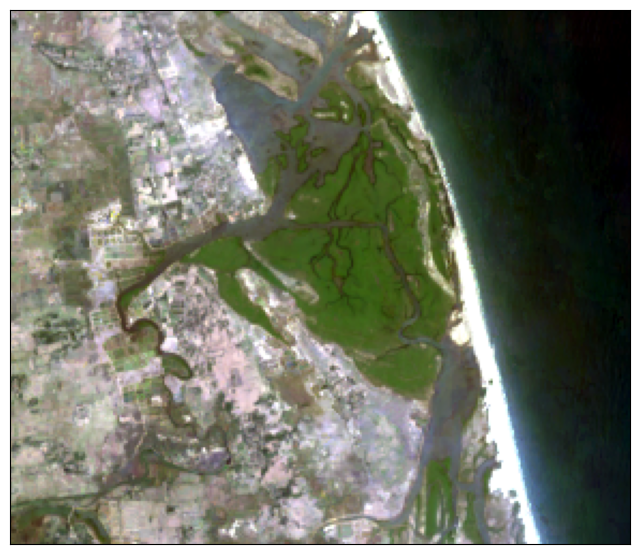

<Axes: >

In [ ]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [4, 3, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

B1        B2        B3      B4        B5        B6        B7  \
2654  0.06060  0.072550  0.092000  0.0763  0.077300  0.042750  0.042800   
2057  0.06570  0.081500  0.109500  0.0902  0.138200  0.232100  0.302200   
7138  0.77169  0.810844  0.972192  0.8935  1.680483  1.184857  0.921792   
4517  0.06010  0.067100  0.077800  0.0421  0.041600  0.032600  0.032400   
3054  0.05750  0.064900  0.079150  0.0684  0.070550  0.034900  0.035850   
...       ...       ...       ...     ...       ...       ...       ...   
425   0.05690  0.063200  0.068300  0.0393  0.039300  0.032000  0.031400   
2918  0.05630  0.063000  0.078300  0.0676  0.066600  0.031500  0.034200   
3189  0.07710  0.093300  0.130300  0.1772  0.191800  0.223400  0.228100   
5741  0.05660  0.066600  0.067700  0.0368  0.038500  0.030700  0.033900   
4166  0.07040  0.082000  0.109100  0.1218  0.151400  0.159100  0.172900   

      classvalue sample  
2654           1  train  
2057           1  train  
7138           3  train  
4517           1  train  
3054           1  train  
...          ...    ...  
425            1  train  
2918           1  train  
3189           1  train  
5741           1   test  
4166           1  train  

[7592 rows x 9 columns]

In [ ]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1).astype(int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1).astype(int)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (6252, 7, 1)
Test features: (1340, 7, 1)
Train label: (6252, 7)
Test label: (1340, 7)


In [ ]:
from tensorflow.keras.layers import BatchNormalization
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])
# Model parameter
neuron = 128
drop = 0.2
kernel = 1
# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  BatchNormalization(),
  Conv1D(neuron * 1, kernel, activation='relu'),
  BatchNormalization(),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  BatchNormalization(),
  Conv1D(neuron * 2, kernel, activation='relu'),
  BatchNormalization(),
  Dropout(drop),
  Conv1D(neuron * 4, kernel, activation='relu'),
  BatchNormalization(),
  Conv1D(neuron * 4, kernel, activation='relu'),
  BatchNormalization(),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 4, activation='relu'),
  Dropout(drop),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 128)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 7, 256)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 7, 256)              │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 7, 512)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 7, 512)              │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │              

 Total params: 944,775 (3.60 MB)

 Trainable params: 941,191 (3.59 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)


# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
from sklearn.utils.class_weight import compute_class_weight




# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    #callbacks=[stop],
    epochs=300,
)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5377 - loss: 1.8045 - val_accuracy: 0.7985 - val_loss: 1.8040
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8152 - loss: 0.7263 - val_accuracy: 0.7985 - val_loss: 1.5531
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8420 - loss: 0.4656 - val_accuracy: 0.7985 - val_loss: 1.2749
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8621 - loss: 0.3472 - val_accuracy: 0.7985 - val_loss: 1.0772
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8613 - loss: 0.3279 - val_accuracy: 0.7985 - val_loss: 0.9548
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8735 - loss: 0.3041 - val_accuracy: 0.7985 - val_loss: 0.9063
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8682 - loss: 0.3122 - val_accuracy: 0.7985 - val_loss: 0.8390
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8753 - loss: 0.2952 - val_accuracy: 0.7985 - val_loss: 

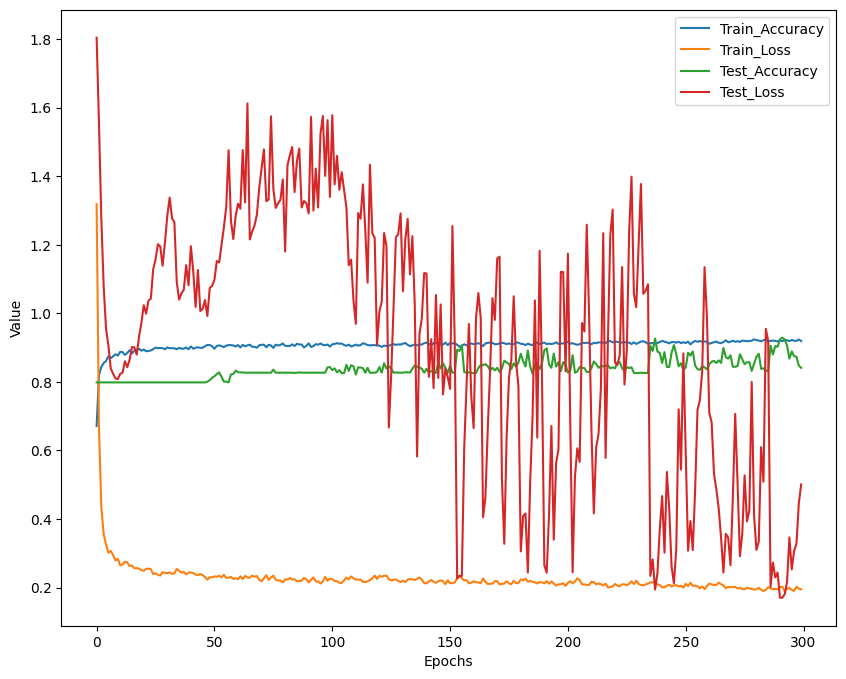

In [ ]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
              precision    recall  f1-score   support

           1       0.91      1.00      0.95      1070
           2       0.36      0.56      0.44        94
           3       0.00      0.00      0.00       103
           4       1.00      0.08      0.15        73

    accuracy                           0.84      1340
   macro avg       0.57      0.41      0.39      1340
weighted avg       0.81      0.84      0.80      1340



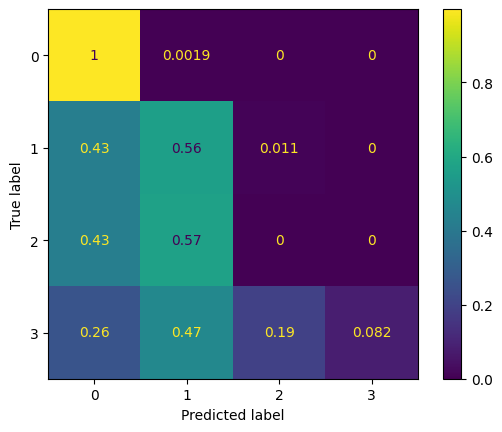

In [ ]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


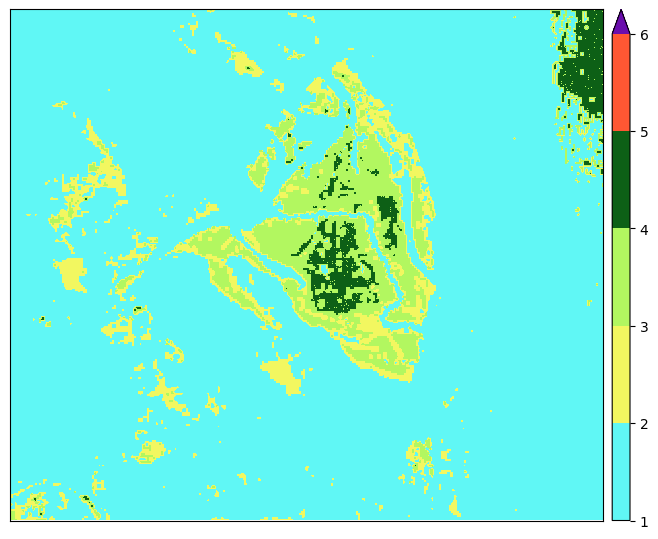

<Axes: >

In [ ]:
# Predict image using the model
image_input = []
for x in range(7):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(7, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

In [ ]:
years_arr=[2014,2016,2018,2020,2022,2024]
sparse_arr=[]
moderate_arr=[]
dense_arr=[]
mangroves_arr=[]
others_arr=[]

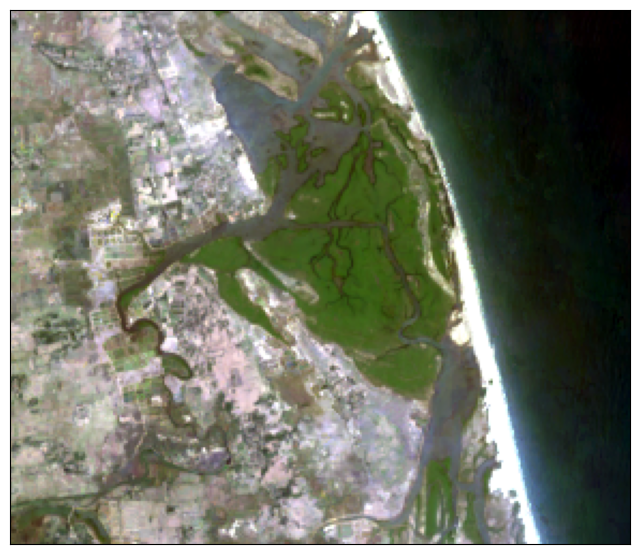

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


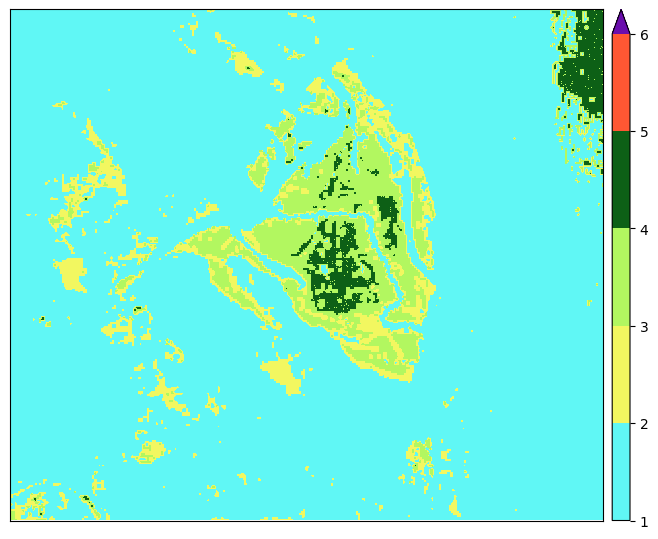

Percentage of class 1: 79.32%
Percentage of class 2: 7.94%
Percentage of class 3: 7.82%
Percentage of class 4: 4.93%


<Figure size 640x480 with 0 Axes>

In [ ]:
#2014
IMAGE_PATH = '/content/drive/MyDrive/FIN_DL-20240505T064913Z-001/FIN_DL/2014.tif'
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)
image_vis = []
for x in [4, 3, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Predict image using the model
image_input = []
for x in range(7):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(7, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)
plt.savefig('visualization.png', bbox_inches='tight')

# percentage of class 1
# Specify the target class
target_class = 1  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class1 = (target_class_count / total_pixels) * 100
others_arr.append(class1)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class1:.2f}%")

# percentage of class 2
# Specify the target class
target_class = 2  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class2 = (target_class_count / total_pixels) * 100
sparse_arr.append(class2)

# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class2:.2f}%")

# percentage of class 3
# Specify the target class
target_class = 3  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class3 = (target_class_count / total_pixels) * 100
moderate_arr.append(class3)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class3:.2f}%")

# percentage of class 4
# Specify the target class
target_class = 4  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class4 = (target_class_count / total_pixels) * 100
dense_arr.append(class4)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class4:.2f}%")

allclasses=class2+class3+class4
mangroves_arr.append(allclasses)

In [ ]:

print("Sparese:  ",sparse_arr)
print("Moderate:  ",moderate_arr)
print("Dense:  ",dense_arr)


Sparese:   [7.939022526090521]
Moderate:   [7.815344422673393]
Dense:   [4.926279512513722]


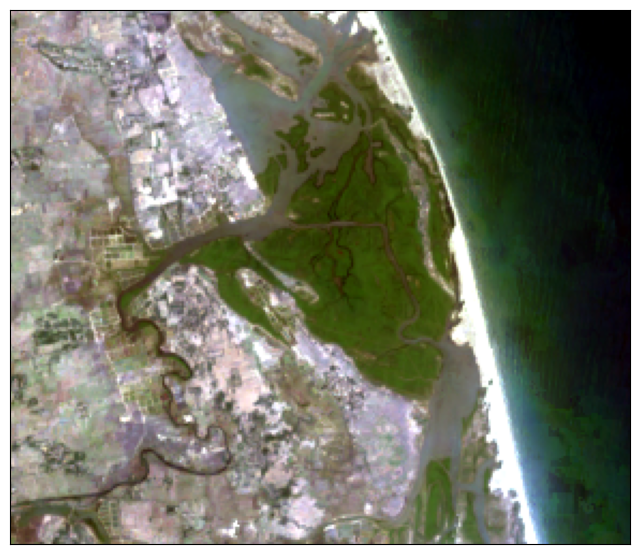

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


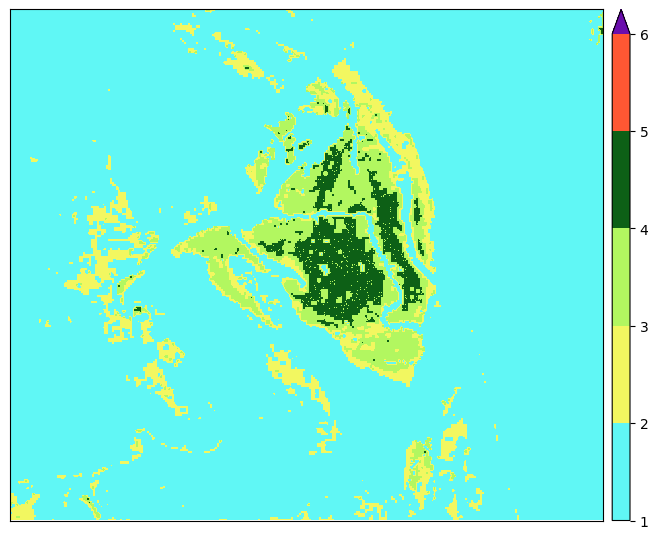

Percentage of class 1: 79.77%
Percentage of class 2: 9.39%
Percentage of class 3: 5.28%
Percentage of class 4: 5.56%


<Figure size 640x480 with 0 Axes>

In [ ]:
#2016
IMAGE_PATH = '/content/drive/MyDrive/FIN_DL-20240505T064913Z-001/FIN_DL/2016.tif'
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)
image_vis = []
for x in [4, 3, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Predict image using the model
image_input = []
for x in range(7):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(7, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)
plt.savefig('visualization.png', bbox_inches='tight')

# percentage of class 1
# Specify the target class
target_class = 1  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class1 = (target_class_count / total_pixels) * 100
others_arr.append(class1)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class1:.2f}%")

# percentage of class 2
# Specify the target class
target_class = 2  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class2 = (target_class_count / total_pixels) * 100
sparse_arr.append(class2)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class2:.2f}%")

# percentage of class 3
# Specify the target class
target_class = 3  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class3 = (target_class_count / total_pixels) * 100
moderate_arr.append(class3)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class3:.2f}%")

# percentage of class 4
# Specify the target class
target_class = 4  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class4 = (target_class_count / total_pixels) * 100
dense_arr.append(class4)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class4:.2f}%")
allclasses=class2+class3+class4
mangroves_arr.append(allclasses)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


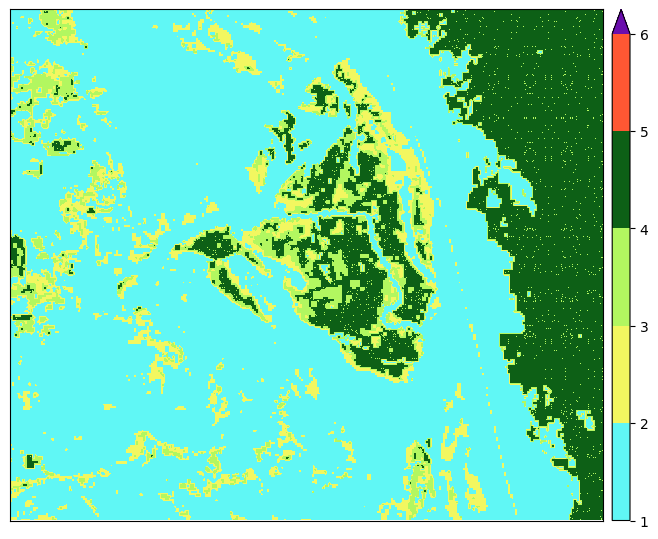

Percentage of class 1: 58.31%
Percentage of class 2: 10.55%
Percentage of class 3: 4.80%
Percentage of class 4: 26.34%


<Figure size 640x480 with 0 Axes>

In [ ]:
#2018
IMAGE_PATH = '/content/drive/MyDrive/FIN_DL-20240505T064913Z-001/FIN_DL/2018.tif'
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)
image_vis = []
for x in [4, 3, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
plot_size = (8, 8)
'''ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)'''

# Predict image using the model
image_input = []
for x in range(7):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(7, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)
plt.savefig('visualization.png', bbox_inches='tight')

# percentage of class 1
# Specify the target class
target_class = 1  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class1 = (target_class_count / total_pixels) * 100
others_arr.append(class1)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class1:.2f}%")

# percentage of class 2
# Specify the target class
target_class = 2  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class2 = (target_class_count / total_pixels) * 100
sparse_arr.append(class2)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class2:.2f}%")

# percentage of class 3
# Specify the target class
target_class = 3  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class3 = (target_class_count / total_pixels) * 100
moderate_arr.append(class3)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class3:.2f}%")

# percentage of class 4
# Specify the target class
target_class = 4  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class4 = (target_class_count / total_pixels) * 100
dense_arr.append(class4)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class4:.2f}%")
allclasses=class2+class3+class4
mangroves_arr.append(allclasses)

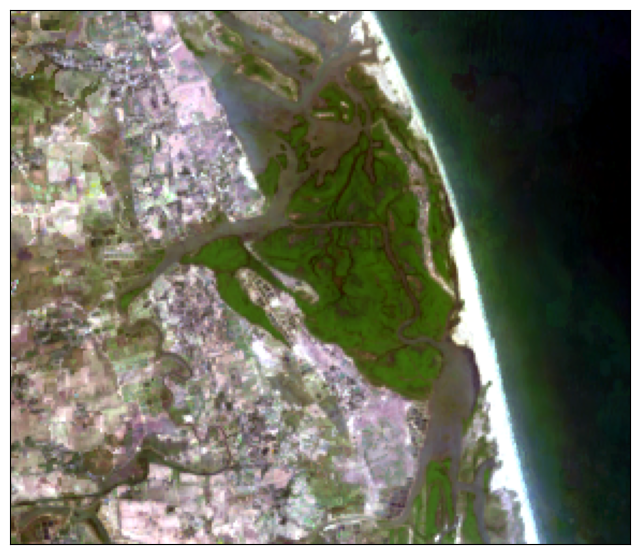

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


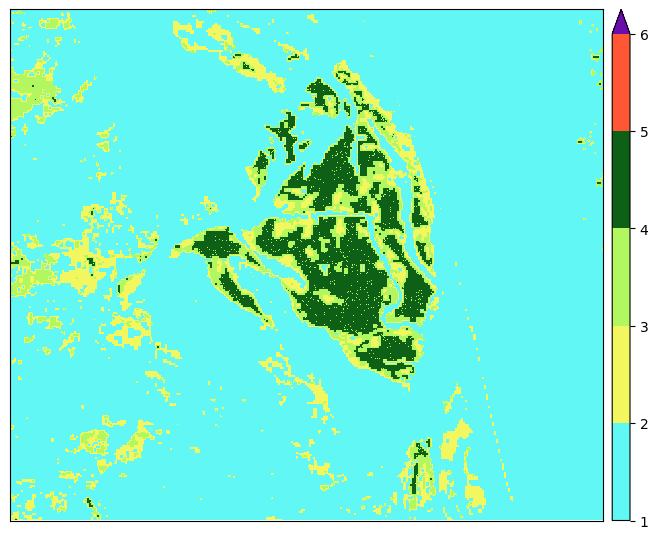

Percentage of class 1: 76.66%
Percentage of class 2: 9.41%
Percentage of class 3: 4.59%
Percentage of class 4: 9.34%


<Figure size 640x480 with 0 Axes>

In [ ]:
#2020
IMAGE_PATH = '/content/drive/MyDrive/FIN_DL-20240505T064913Z-001/FIN_DL/2020.tif'
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)
image_vis = []
for x in [4, 3, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Predict image using the model
image_input = []
for x in range(7):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(7, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)
plt.savefig('visualization.png', bbox_inches='tight')

# percentage of class 1
# Specify the target class
target_class = 1  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class1 = (target_class_count / total_pixels) * 100
others_arr.append(class1)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class1:.2f}%")

# percentage of class 2
# Specify the target class
target_class = 2  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class2 = (target_class_count / total_pixels) * 100
sparse_arr.append(class2)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class2:.2f}%")

# percentage of class 3
# Specify the target class
target_class = 3  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class3 = (target_class_count / total_pixels) * 100
moderate_arr.append(class3)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class3:.2f}%")

# percentage of class 4
# Specify the target class
target_class = 4  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class4 = (target_class_count / total_pixels) * 100
dense_arr.append(class4)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class4:.2f}%")
allclasses=class2+class3+class4
mangroves_arr.append(allclasses)

/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


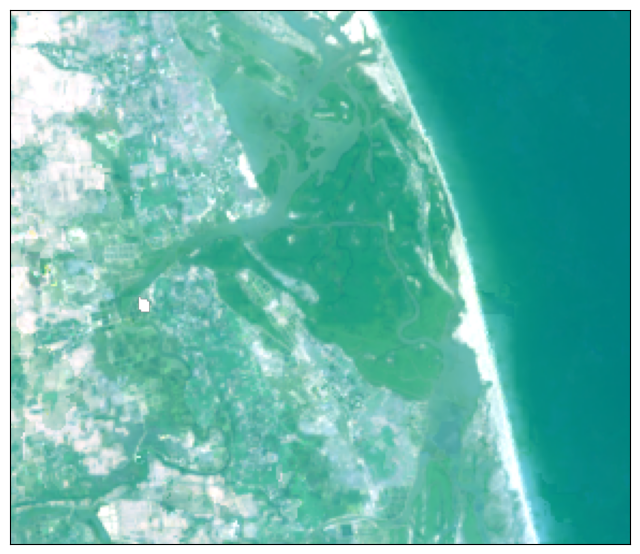

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


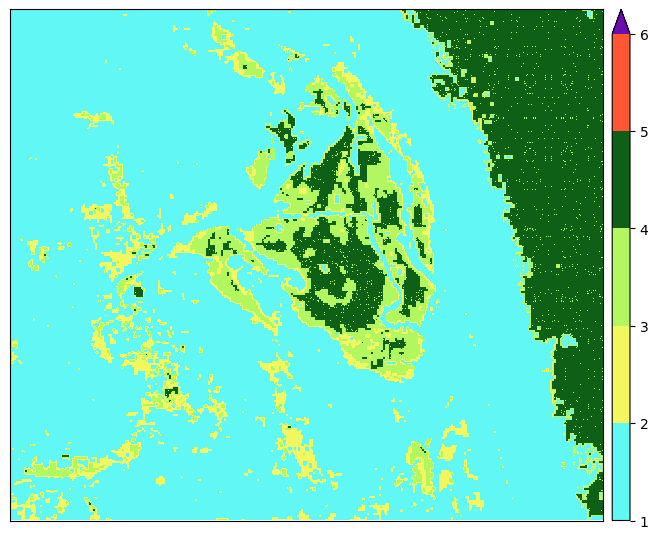

Percentage of class 1: 63.36%
Percentage of class 2: 8.45%
Percentage of class 3: 6.29%
Percentage of class 4: 21.89%


<Figure size 640x480 with 0 Axes>

In [ ]:
#2024
IMAGE_PATH = '/content/drive/MyDrive/FIN_DL-20240505T064913Z-001/FIN_DL/2024.tif'
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)
image_vis = []
for x in [4, 3, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Predict image using the model
image_input = []
for x in range(7):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(7, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)
plt.savefig('visualization.png', bbox_inches='tight')

# percentage of class 1
# Specify the target class
target_class = 1  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class1 = (target_class_count / total_pixels) * 100
others_arr.append(class1)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class1:.2f}%")

# percentage of class 2
# Specify the target class
target_class = 2  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class2 = (target_class_count / total_pixels) * 100
sparse_arr.append(class2)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class2:.2f}%")

# percentage of class 3
# Specify the target class
target_class = 3  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class3 = (target_class_count / total_pixels) * 100
moderate_arr.append(class3)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class3:.2f}%")

# percentage of class 4
# Specify the target class
target_class = 4  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class4 = (target_class_count / total_pixels) * 100
dense_arr.append(class4)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class4:.2f}%")
allclasses=class2+class3+class4
mangroves_arr.append(allclasses)

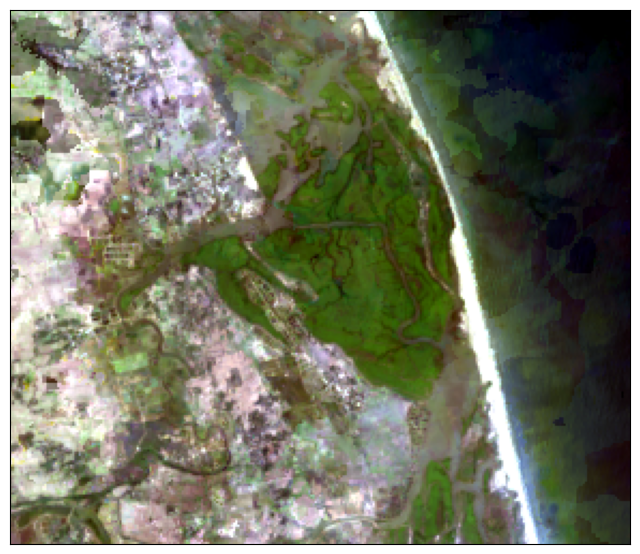

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


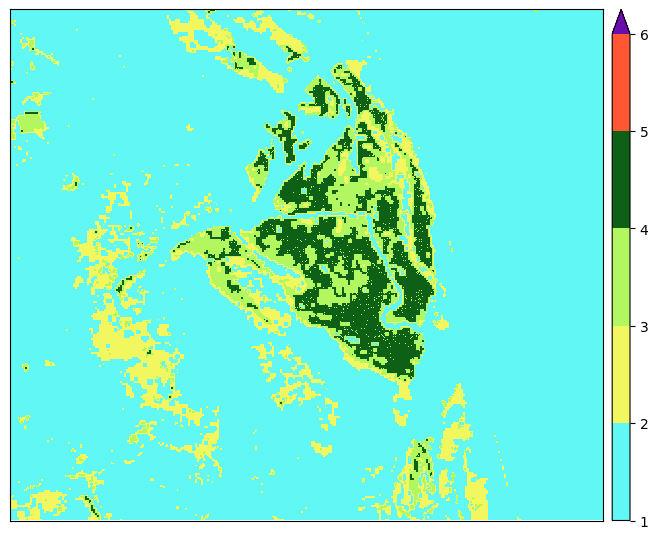

Percentage of class 1: 74.90%
Percentage of class 2: 11.32%
Percentage of class 3: 4.18%
Percentage of class 4: 9.61%


<Figure size 640x480 with 0 Axes>

In [ ]:
#2022
IMAGE_PATH = '/content/drive/MyDrive/FIN_DL-20240505T064913Z-001/FIN_DL/2022.tif'
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)
image_vis = []
for x in [4, 3, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)
plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Predict image using the model
image_input = []
for x in range(7):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(7, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)
plt.savefig('visualization.png', bbox_inches='tight')

# percentage of class 1
# Specify the target class
target_class = 1  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class1 = (target_class_count / total_pixels) * 100
others_arr.append(class1)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class1:.2f}%")

# percentage of class 2
# Specify the target class
target_class = 2  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class2 = (target_class_count / total_pixels) * 100
sparse_arr.append(class2)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class2:.2f}%")

# percentage of class 3
# Specify the target class
target_class = 3  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class3 = (target_class_count / total_pixels) * 100
moderate_arr.append(class3)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class3:.2f}%")

# percentage of class 4
# Specify the target class
target_class = 4  # Replace with the desired class number

# Isolate the class of interest
target_class_pixels = prediction == target_class

# Calculate total number of pixels
total_pixels = prediction.shape[0] * prediction.shape[1]

# Count the target class pixels
target_class_count = target_class_pixels.sum()

# Calculate the percentage
class4 = (target_class_count / total_pixels) * 100
dense_arr.append(class4)
# Print the percentage for the target class
print(f"Percentage of class {target_class}: {class4:.2f}%")
allclasses=class2+class3+class4
mangroves_arr.append(allclasses)

In [ ]:
print("Years",years_arr)
print("Sparse:  ",sparse_arr)
print("Moderate:  ",moderate_arr)
print("Dense:  ",dense_arr)
print("Mangroves: ",mangroves_arr)
print("Non-mangroves :",others_arr)


Years [2014, 2016, 2018, 2020, 2022, 2024]
Sparse:   [7.939022526090521, 9.387029085198927, 10.550159113964508, 9.41065299259321, 8.454579563930462, 11.31863092508442]
Moderate:   [7.815344422673393, 5.2764691985936825, 4.803991050708023, 4.592765525770904, 6.290907574936424, 4.178652325565237]
Dense:   [4.926279512513722, 5.562735370547936, 26.337877461402705, 9.337001987187504, 21.89102430483178, 9.606592459804617]
Mangroves:  [20.680646461277636, 20.226233654340547, 41.69202762607524, 23.34042050555162, 36.636511443698666, 25.103875710454275]
Non-mangroves : [79.31935353872235, 79.77376634565945, 58.30797237392476, 76.65957949444838, 63.36348855630133, 74.89612428954572]


Text(0.5, 1.0, 'TIME SERIES PLOT - YEARS vs SPARSE / OPEN CANOPY EXTENT')

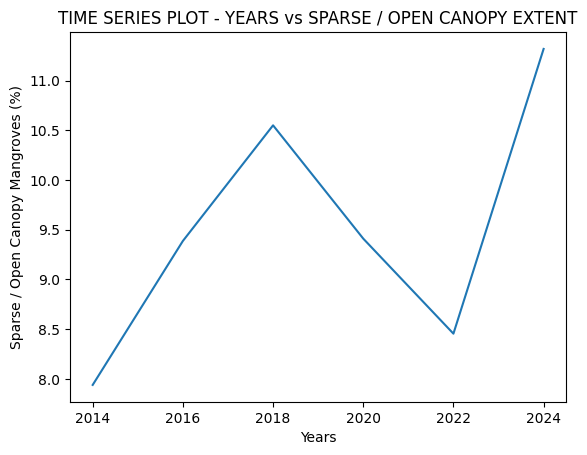

In [ ]:
plt.xlabel('Years')
plt.ylabel('Sparse / Open Canopy Mangroves (%)')
plt.plot(years_arr,sparse_arr)
plt.title('TIME SERIES PLOT - YEARS vs SPARSE / OPEN CANOPY EXTENT')

Text(0.5, 1.0, 'TIME SERIES PLOT - YEARS vs MODERATE CANOPY EXTENT')

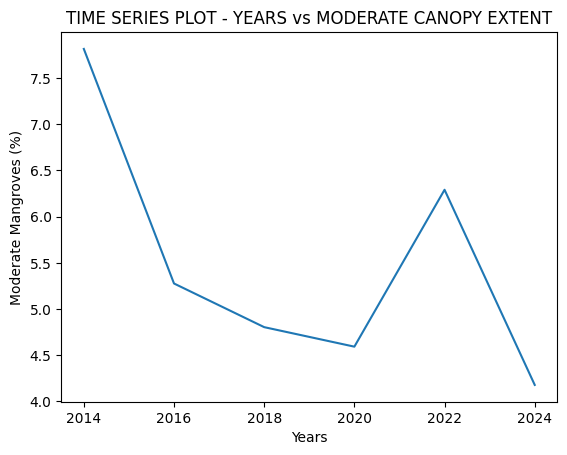

In [ ]:
plt.xlabel('Years')
plt.ylabel('Moderate Mangroves (%)')
plt.plot(years_arr,moderate_arr)
plt.title('TIME SERIES PLOT - YEARS vs MODERATE CANOPY EXTENT')

Text(0.5, 1.0, 'TIME SERIES PLOT - YEARS vs DENSE / CLOSED CANOPY EXTENT')

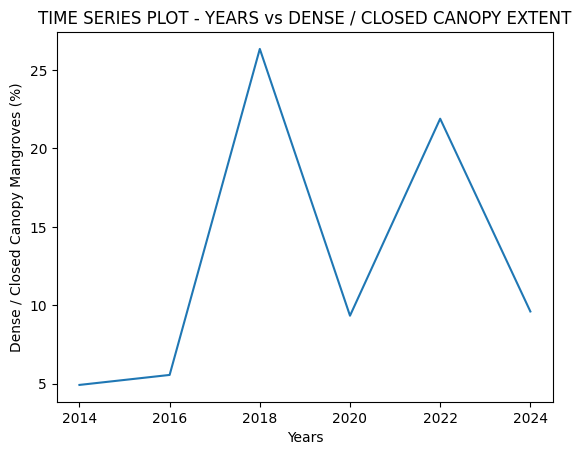

In [ ]:
plt.xlabel('Years')
plt.ylabel('Dense / Closed Canopy Mangroves (%)')
plt.plot(years_arr,dense_arr)
plt.title('TIME SERIES PLOT - YEARS vs DENSE / CLOSED CANOPY EXTENT')

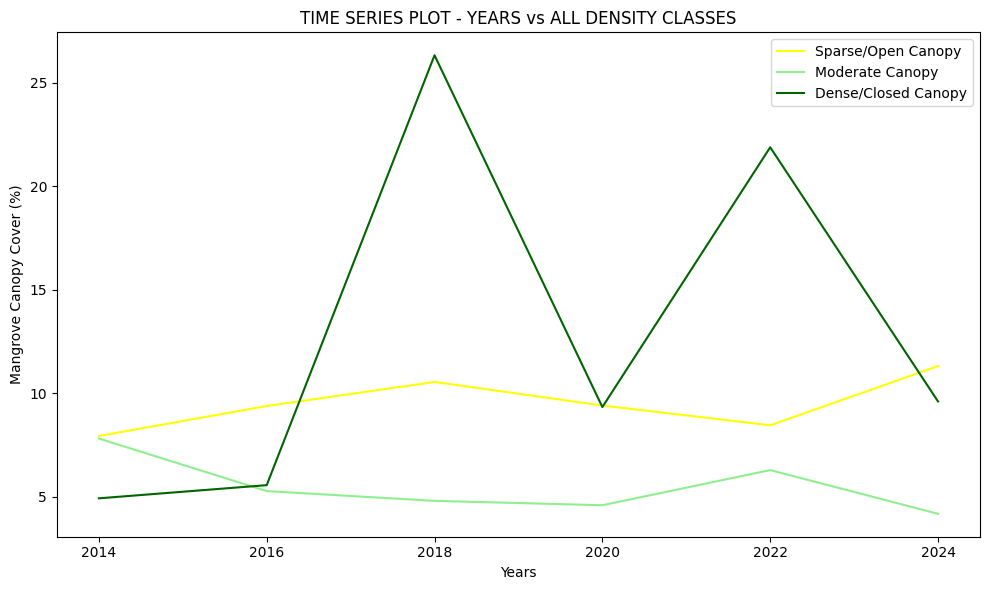

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have your data in years_arr, sparse_arr, moderate_arr, and dense_arr

# Create the main figure and plot area
plt.figure(figsize=(10, 6))

# Plot sparse canopy (yellow line)
plt.plot(years_arr, sparse_arr, label='Sparse/Open Canopy', color='yellow')

# Plot moderate canopy (light green line)
plt.plot(years_arr, moderate_arr, label='Moderate Canopy', color='lightgreen')

# Plot dense canopy (dark green line)
plt.plot(years_arr, dense_arr, label='Dense/Closed Canopy', color='darkgreen')

# Set labels and title
plt.xlabel('Years')
plt.ylabel('Mangrove Canopy Cover (%)')
plt.title('TIME SERIES PLOT - YEARS vs ALL DENSITY CLASSES')

# Add legend
plt.legend()

# Show the plot

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'TIME SERIES PLOT - YEARS vs OVERALL MANGROVES EXTENT')

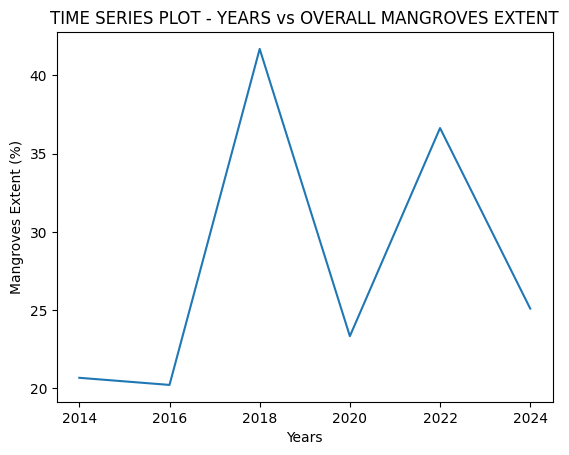

In [ ]:
plt.xlabel('Years')
plt.ylabel('Mangroves Extent (%)')
plt.plot(years_arr,mangroves_arr)
plt.title('TIME SERIES PLOT - YEARS vs OVERALL MANGROVES EXTENT')

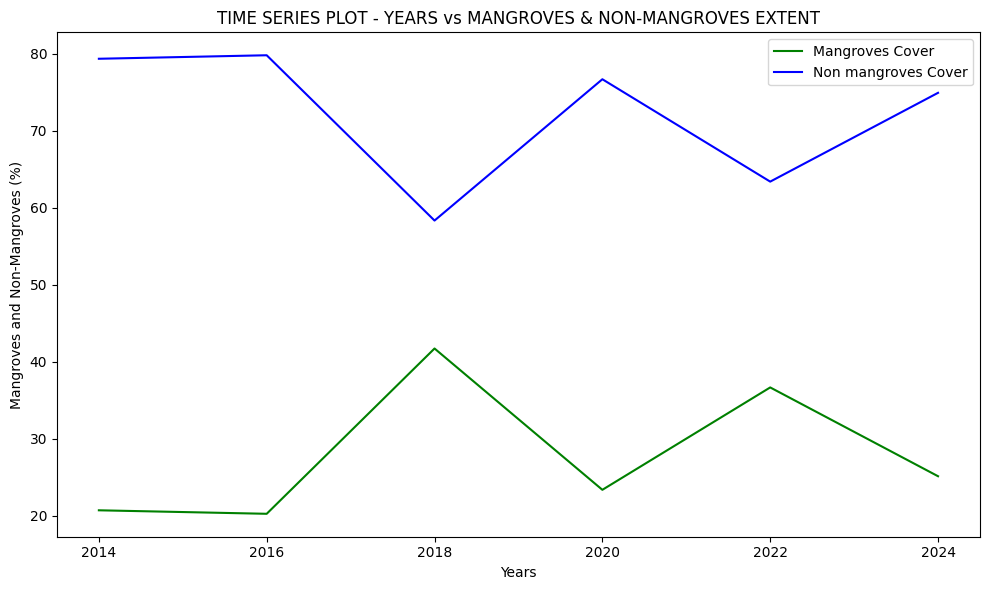

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have your data in years_arr, sparse_arr, moderate_arr, and dense_arr

# Create the main figure and plot area
plt.figure(figsize=(10, 6))

# Plot sparse canopy (yellow line)
plt.plot(years_arr, mangroves_arr, label='Mangroves Cover', color='Green')

# Plot moderate canopy (light green line)
plt.plot(years_arr, others_arr, label='Non mangroves Cover', color='Blue')

# Set labels and title
plt.xlabel('Years')
plt.ylabel('Mangroves and Non-Mangroves (%)')
plt.title('TIME SERIES PLOT - YEARS vs MANGROVES & NON-MANGROVES EXTENT')

# Add legend
plt.legend()

# Show the plot

plt.tight_layout()
plt.show()
